Train an embedding given a batch of data collected by a successful run.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import tensorflow as tf
import glob
import math
import skimage

tf.enable_eager_execution()

In [25]:
from IPython.display import clear_output

In [26]:
from softlearning.replay_pools.utils import get_replay_pool_from_variant

def get_grid_vals(env, n_samples):
    n_samples = 50
    obs_space = env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)
    xys = np.meshgrid(xs, ys)
    return np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2)), xys

def get_replay_pool(checkpoint, checkpoint_dir):
    from softlearning.replay_pools.utils import get_replay_pool_from_variant

    variant = checkpoint['variant']
    train_env = checkpoint['training_environment']
    replay_pool = get_replay_pool_from_variant(variant, train_env)

    replay_pool_path = os.path.join(checkpoint_dir, 'replay_pool.pkl')
    replay_pool.load_experience(replay_pool_path)
    return replay_pool

def plot_embedding_distances(pos_embedding=None, goal_embedding=None):
    pos_embedding = pos_embedding or embedding_fns[0]
    goal_embedding = goal_embedding or embedding_fns[1]
    
    target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

    n_samples = 50
    obs_space = train_env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)

    xys = np.meshgrid(xs, ys)

    grid_vals = np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2))
    goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
    dists = np.linalg.norm(goal_embedding.predict(goal_vals) - pos_embedding.predict(grid_vals), axis=-1)

    plt.figure(figsize=(8, 8))

    plt.imshow(train_env.render('rgb_array', width=256, height=256),
               extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

    plt.gca().invert_yaxis()
    plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=30, zorder=1, cmap='viridis_r')
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

    plt.title(f'|phi(g) - phi(s)| for {domain + task} Task'
              + f'Target Pos: {target_pos}')
    plt.show()

def plot_trajectories(checkpoint, checkpoint_dir, num_trajectories=10):
    replay_pool = get_replay_pool(checkpoint, checkpoint_dir)
    trajectories = replay_pool.last_n_batch(100 * num_trajectories)['observations']['state_observation'] \
                    .reshape(num_trajectories, 100, -1)
    for i in range(num_trajectories):
        plt.plot(trajectories[i,:,0], trajectories[i,:,1], color='w', linewidth=1)

## Load Run

In [27]:
common_dir = '/Users/kevintli/rail/data/ray_results'
universe = 'gym'
domain = 'Point2D'
task = 'Maze-v0'

In [28]:
base_path = os.path.join(common_dir, universe, domain, task)
exps = sorted(list(glob.iglob(os.path.join(base_path, '*'))))
for i, exp in enumerate(exps):
    print(f'{i} \t {exp.replace(base_path, "")}')
    
exp_choice = int(input('\n Which experiment do you want to analyze? (ENTER A NUMBER) \t'))

exp_path = exps[exp_choice]
print('\n')
seeds = sorted(list(glob.iglob(os.path.join(exp_path, '*'))))
seeds = [seed for seed in seeds if os.path.isdir(seed)]
for i, seed in enumerate(seeds):
    print(f'{i} \t {seed.replace(exp_path, "")}')
    
# TODO: Extend to analyzing all seeds
seed_choice = int(input('\n Which seed do you want to analyze? (ENTER A NUMBER) \t'))

seed_path = seeds[seed_choice]

print('PATH:\n', seed_path)

0 	 /2020-05-27T16-46-37-ddl_maze
1 	 /2020-05-27T18-08-07-ddl_maze_count
2 	 /2020-05-28T15-34-01-dynamics_aware_vice
3 	 /2020-05-31T05-25-18-vice_gt_embedding
4 	 /2020-06-02T01-19-37-test_logp_vice_gt_embedding
5 	 /2020-06-02T02-47-31-vice_gt_embedding_rerun
6 	 /2020-06-02T03-22-25-vice_gt_embedding_more_reg
7 	 /2020-06-02T10-48-03-vice_gt_embedding_again
8 	 /2020-06-03T00-23-13-high_reg_vice
9 	 /2020-06-03T06-19-35-vice_dropout_and_wd
10 	 /seed-7025
11 	 /videos-2320
12 	 /videos-7777
13 	 /videos2

 Which experiment do you want to analyze? (ENTER A NUMBER) 	9


0 	 /dea4faee-algorithm=VICE-seed=3351_2020-06-03_06-19-353061b3tw
1 	 /dea5a6d8-algorithm=VICE-seed=9850_2020-06-03_06-19-36wghlk4uo
2 	 /dea627a2-algorithm=VICE-seed=2790_2020-06-03_06-19-36otchx9h1
3 	 /dea91c82-algorithm=VICE-seed=8031_2020-06-03_06-19-36fx668ydh
4 	 /deabda80-algorithm=VICE-seed=483_2020-06-03_06-19-36yhcodgfc
5 	 /dead6742-algorithm=VICE-seed=2259_2020-06-03_06-19-37qg8wbhps
6 	 /deade9a6-algor

### Initialize Replay Pool & Load Experience from All Checkpoints

In [29]:
from softlearning.replay_pools.utils import get_replay_pool_from_variant

checkpoint, variant, train_env, replay_pool = None, None, None, None

for seed_path in seeds:
    for ckpt_path in glob.iglob(os.path.join(seed_path, 'checkpoint_*')):
        if not replay_pool:
            with open(os.path.join(ckpt_path, 'checkpoint.pkl'), 'rb') as f:
                checkpoint = pickle.load(f)    
            variant = checkpoint['variant']
            variant['replay_pool_params']['kwargs']['max_size'] = int(1e6)
            train_env = checkpoint['training_environment']
            replay_pool = get_replay_pool_from_variant(variant, train_env)

        replay_pool_path = os.path.join(ckpt_path, 'replay_pool.pkl')
        replay_pool.load_experience(replay_pool_path)

W0603 18:26:55.497646 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [30]:
replay_pool.size

1000000

In [31]:
max_path_length = variant['sampler_params']['kwargs']['max_path_length']
max_path_length

100

In [32]:
c_num = 200
with open(os.path.join(f'{seed_path}/checkpoint_{c_num}', 'checkpoint.pkl'), 'rb') as f:
    checkpoint = pickle.load(f)   

checkpoint.keys()
distance_fn = checkpoint['distance_estimator']

W0603 18:26:59.512883 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


KeyError: 'distance_estimator'

## Initialize the Embedding Function

In [63]:
from softlearning.models.utils import get_embedding_from_variant

variant['distance_fn_params'] = {
    'type': 'feedforward_distance_fn',
    'kwargs': {
        'hidden_layer_sizes': (256, ) * 2,
        'observation_keys': None,
        'embedding_dim': 16,
        'observation_keys': ('state_observation', ),
#         'kernel_regularizer':
        'kernel_regularizer': None
    }
}

embedding_fn = get_embedding_from_variant(variant, train_env)

In [64]:
embedding_fn_copy = tf.keras.models.clone_model(embedding_fn)

In [65]:
embedding_fns = [embedding_fn, embedding_fn_copy]

In [66]:
embedding_fns = [embedding_fn, embedding_fn]

## Training Helper Functions

In [67]:
def get_data(replay_pool, max_path_length, batch_size=256):
    s1_indices = replay_pool.random_indices(batch_size)
#     s1_indices = np.random.randint(success_data.shape[0], size=batch_size)

    # Clip at a certain amount?
    distances = np.minimum(np.random.randint(max_path_length - s1_indices % max_path_length), 10)
    s2_indices = s1_indices + distances

    s1 = replay_pool.batch_by_indices(s1_indices)
    s2 = replay_pool.batch_by_indices(s2_indices)
#     s1 = success_data[s1_indices]
#     s2 = success_data[s2_indices]
    distances = distances.astype(np.float32)[..., None]
    
    return s1, s2, distances

In [68]:
def ground_truth_data(gt_distance_fn, max_path_length, batch_size=256):
    """
    Get data for training a ground truth embedding function
    *using actual replay pool data*.
    
    (This is not currently being used, because we're only training on goal distances, 
    not pairwise distances between arbitrary points)
    """
    s1_indices = replay_pool.random_indices(batch_size)

    # Clip at a certain amount?
    distances = np.minimum(np.random.randint(max_path_length - s1_indices % max_path_length), 10)
    s2_indices = s1_indices + distances

    s1 = replay_pool.batch_by_indices(s1_indices)['observations']['state_observation']
    s2 = replay_pool.batch_by_indices(s2_indices)['observations']['state_observation']
    distances = gt_distance_fn(s1, s2)
    
    return s1, s2, distances

In [69]:
optimizer = tf.compat.v1.train.AdamOptimizer(
    learning_rate=3e-4,
    name='embedding_fn_optimizer')

In [70]:
loss_object = tf.keras.losses.MeanSquaredError()
def loss(models, s1, s2, distance):
    pred = tf.reduce_sum(tf.square(models[1](s2) - models[0](s1)))
#     pred = tf.norm(model(s2) - model(s1))
    return loss_object(y_true=distance, y_pred=pred)

In [71]:
def grad(models, var_list, s1, s2, distance):
    with tf.GradientTape() as tape:
        loss_value = loss(models, s1, s2, distance)
    return loss_value, tape.gradient(loss_value, var_list)

### Train using replay pool data

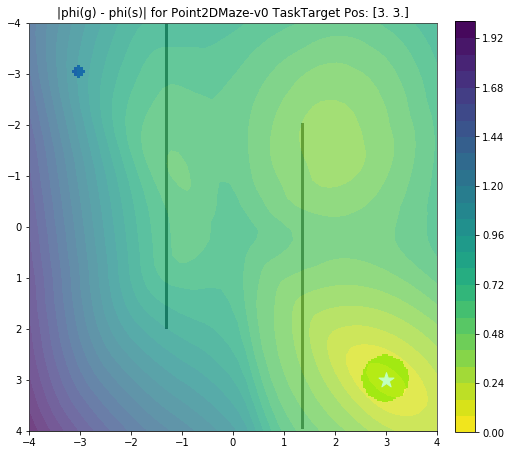

KeyboardInterrupt: 

In [54]:
# Keep results for plotting
train_loss_results = []

if embedding_fns[0] is not embedding_fns[1]:
    var_list = (embedding_fns[0].trainable_variables
                + embedding_fns[1].trainable_variables)
else:
    var_list = embedding_fns[0].trainable_variables
    
def get_ground_truth_data():
    return ground_truth_data(lambda s1, s2: train_env._env.unwrapped._medium_maze_distance({'state_achieved_goal': s1, 'state_desired_goal': s2}), max_path_length, batch_size=batch_size)
    
def get_replay_data():
    return get_data(replay_pool, max_path_length, batch_size=batch_size)


data_sampler_fn = get_ground_truth_data # Change this to switch between training on trajectories vs. ground truth labels
num_epochs = 200
batch_size = 64
# gt_dataset = iter(gt_dataset.shuffle(n_samples * n_samples, reshuffle_each_iteration=True)
#                         .repeat(num_epochs * 10)
#                         .batch(batch_size))
    
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for i in range(10):
        s1, s2, distance = data_sampler_fn()

        loss_value, grads = grad(embedding_fns, var_list, s1, s2, distance)
        optimizer.apply_gradients(zip(grads, var_list))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())

    if epoch % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
    if epoch % 50 == 0:
        clear_output()
        plot_embedding()

In [59]:
n_samples = 50
target_pos = train_env.unwrapped._get_obs()['state_desired_goal']
goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
grid_vals, xys = get_grid_vals(train_env, n_samples)
obs = {
    'state_achieved_goal': grid_vals,
    'state_desired_goal': goal_vals
}

features = grid_vals
labels = train_env._env.unwrapped._medium_maze_distance(obs, dist_type="manhattan")
gt_dataset = tf.data.Dataset.from_tensor_slices((features, labels))

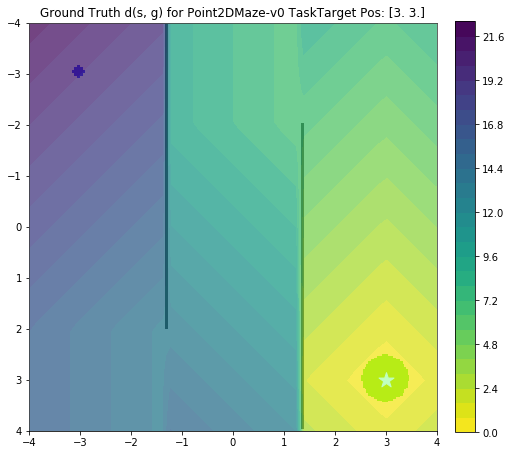

In [72]:
# Plot true distances to learn
plt.figure(figsize=(8, 8))

plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

plt.gca().invert_yaxis()
plt.contourf(xys[0], xys[1], labels.reshape(xys[0].shape), levels=30, zorder=1, cmap='viridis_r')
plt.colorbar(fraction=0.046, pad=0.04)
# plot_trajectories(checkpoint, f'{seed_path}/checkpoint_200')

plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

plt.title(f'Ground Truth d(s, g) for {domain + task} Task'
          + f'Target Pos: {target_pos}')
plt.show()

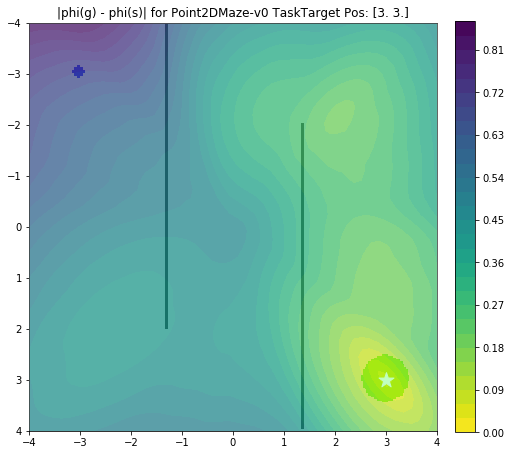

Epoch 160: Loss: 33.832
Epoch 170: Loss: 33.346
Epoch 180: Loss: 33.599
Epoch 190: Loss: 34.294


In [73]:
# Keep results for plotting
train_loss_results = []

if embedding_fns[0] is not embedding_fns[1]:
    var_list = (embedding_fns[0].trainable_variables
                + embedding_fns[1].trainable_variables)
else:
    var_list = embedding_fns[0].trainable_variables
    
num_epochs = 200
batch_size = 64
gt_dataset_iter = iter(gt_dataset.shuffle(n_samples * n_samples, reshuffle_each_iteration=True)
                        .repeat(num_epochs)
                        .batch(batch_size))
    
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for i in range(n_samples * n_samples // batch_size):
        s1, distance = next(gt_dataset_iter)
        s2 = np.repeat(target_pos[None], batch_size, axis=0)

        loss_value, grads = grad(embedding_fns, var_list, s1, s2, distance)
        optimizer.apply_gradients(zip(grads, var_list))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())

    if epoch % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
    if epoch % 50 == 0:
        clear_output()
        plot_embedding()

W0604 00:04:37.108996 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


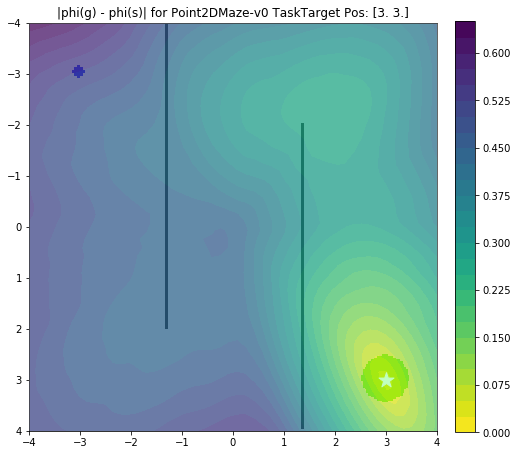

In [62]:
with open('./gt_embedding_fn.pkl', 'rb') as f:
    embedding_fn = pickle.load(f)
plot_embedding_distances()

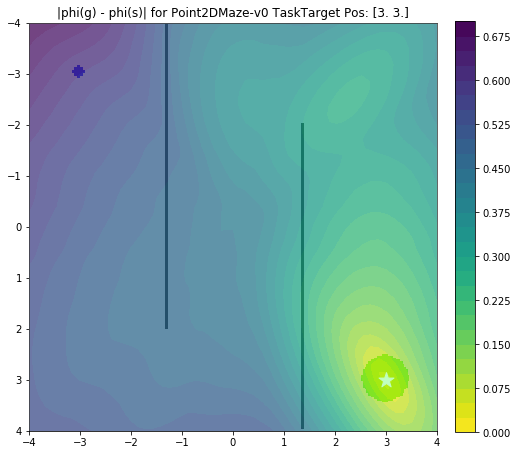

In [23]:
class EmbeddingPlusStateFn:
    def predict(self, pos):
#         return pos
        return np.hstack((embedding_fns[0](pos), pos / 40))
    
plot_embedding_distances(EmbeddingPlusStateFn(), EmbeddingPlusStateFn())

In [64]:
# Visualize using multi-dimensional scaling
from sklearn.datasets import load_digits
from sklearn.manifold import MDS

embeddings = tf.cast(embedding_fns[0](grid_vals), tf.float64)
mds = MDS(n_components=2)
projected = mds.fit_transform(embeddings)
projected

array([[-0.31554488,  0.17343305],
       [-0.31009673,  0.17298813],
       [-0.30355514,  0.17522258],
       ...,
       [ 0.24779701,  0.36604338],
       [ 0.26980394,  0.38098246],
       [ 0.29398582,  0.39358962]])

In [104]:
i = np.argmin(np.linalg.norm(projected - np.array([0.15, 0.15]), axis=-1))
print(f"i={i}")
print(f"projected: {projected[i]}")
print(f"embedding: {embeddings[i]}")
print(f"grid val: {grid_vals[i]}")

i=1741
projected: [0.15150291 0.15365431]
embedding: [ 0.06537004  0.03340905 -0.02697718 -0.09614056 -0.11974018  0.01433774
  0.0233537  -0.03527851  0.01787223 -0.32985267 -0.01815822  0.03813238
  0.07261398  0.10832389  0.04391887  0.1593958 ]
grid val: [2.69387755 1.55102041]


In [76]:
np.repeat([[255, 255, 255]], 5, axis=0)
labels

array([22.        , 21.83673469, 21.67346939, ...,  1.67346939,
        1.83673469,  2.        ])

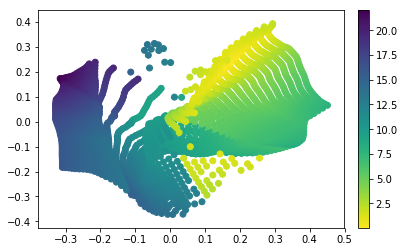

In [80]:
colors = np.repeat([[0, 0, 0]], len(projected), axis=0)
plt.scatter(projected[:,0], projected[:,1], c=labels, cmap='viridis_r')
plt.colorbar(fraction=0.046, pad=0.04)

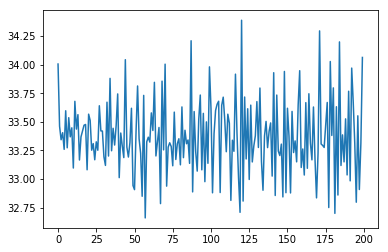

In [125]:
plt.plot(train_loss_results)

In [126]:
with open('./gt_embedding_fn.pkl', 'wb') as f:
    pickle.dump(embedding_fn, f)

In [117]:
%ls

Untitled.ipynb                    gt_embedding_fn.pkl
ddl.ipynb                         pnml.ipynb
embedding_fn_2.pkl                train_embedding.ipynb
embedding_fn_seed0.pkl            vice_reward_visualizations.ipynb
embedding_fn_seed6.pkl


### Train using ground truth distances

In [ ]:
# Keep results for plotting
train_loss_results = []

num_epochs = 1000
batch_size = 64

if embedding_fns[0] is not embedding_fns[1]:
    var_list = (embedding_fns[0].trainable_variables
                + embedding_fns[1].trainable_variables)
else:
    var_list = embedding_fns[0].trainable_variables
    
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for i in range(10):
        s1, s2, distance = get_data(replay_pool,
                                    max_path_length,
                                    batch_size=batch_size)

        loss_value, grads = grad(embedding_fns, var_list, s1, s2, distance)
        optimizer.apply_gradients(zip(grads, var_list))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())

    if epoch % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
    if epoch % 50 == 0:
        clear_output()
        plot_embedding()

### Plot distance predictions using the learned embedding

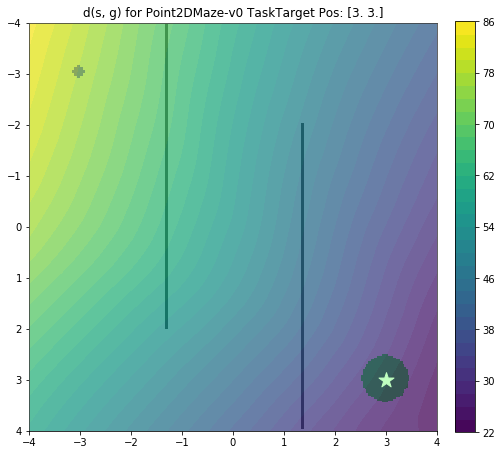

In [96]:
target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

n_samples = 50
obs_space = train_env.observation_space['state_observation']
xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)

xys = np.meshgrid(xs, ys)

grid_vals = np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2))
goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
dists = distance_fn.predict([grid_vals, goal_vals])

plt.figure(figsize=(8, 8))

plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

plt.gca().invert_yaxis()
plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=30, zorder=1)
plt.colorbar(fraction=0.046, pad=0.04)

plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

plt.title(f'd(s, g) for {domain + task} Task'
          + f'Target Pos: {target_pos}')
plt.show()

In [21]:
def plot_embedding():
    target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

    n_samples = 50
    obs_space = train_env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)

    xys = np.meshgrid(xs, ys)

    grid_vals = np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2))
    goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
    dists = np.linalg.norm(embedding_fns[1].predict(goal_vals) - embedding_fns[0].predict(grid_vals), axis=-1)

    plt.figure(figsize=(8, 8))

    plt.imshow(train_env.render('rgb_array', width=256, height=256),
               extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

    plt.gca().invert_yaxis()
    plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=30, zorder=1, cmap='viridis_r')
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

    plt.title(f'|phi(g) - phi(s)| for {domain + task} Task'
              + f'Target Pos: {target_pos}')
    plt.show()

NameError: name 'target_pos' is not defined

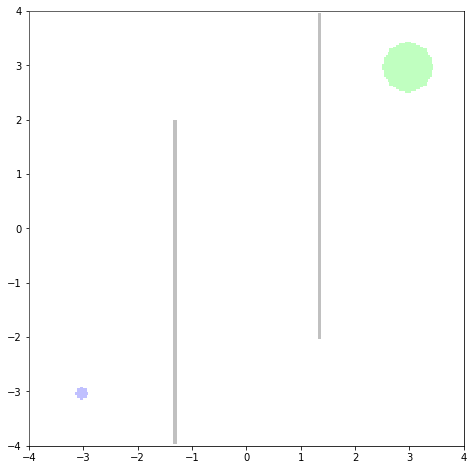

In [29]:
num_traj = 20

trajs = replay_pool.last_n_batch(max_path_length * num_traj)

plt.figure(figsize=(8, 8))

plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)
plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

for i in range(num_traj):
    trajectory = trajs['observations']['state_observation'][i*max_path_length:max_path_length*(i+1)]
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'black')

radii = np.arange(0.5, 9, 0.5)
circles = []
for r in radii:
    pts = []
    for theta in np.arange(0, 2 * np.pi + np.pi / 30, np.pi / 30):
        dx = r * np.cos(theta)
        dy = r * np.sin(theta)
        pt = target_pos + np.array([dx, dy])
        x, y = pt
        if -4 <= x and x <= 4 and -4 <= y and y <= 4:
            pts.append(np.array([[x, y]]))
    circles.append(np.vstack(pts))

for circle in circles:
    plt.plot(circle[:, 0], circle[:, 1])
    
plt.gca().invert_yaxis()

plt.title(f'|phi(g) - phi(s)| for {domain + task} Task\n'
          + f'Target Pos: {target_pos}')
plt.show()

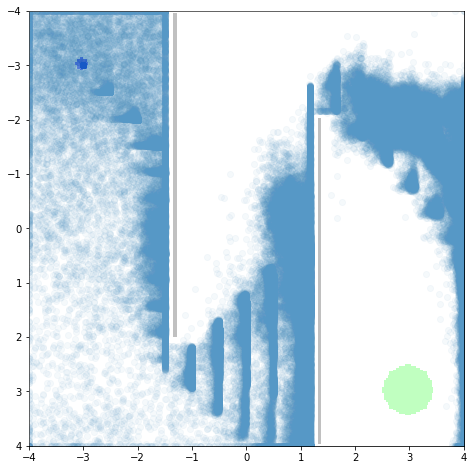

In [30]:
non_zero_rows = replay_pool.data[('observations', 'state_observation')].any(axis=-1)
visitations = replay_pool.data[('observations', 'state_observation')][non_zero_rows]
plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().invert_yaxis()
plt.imshow(train_env.render('rgb_array'),
           extent=(-4, 4, -4, 4),
           origin='lower',
           alpha=0.25,
           zorder=3,
           interpolation='nearest')

plt.scatter(visitations[:, 0], visitations[:, 1], alpha=0.05)

ValueError: need at least one array to concatenate

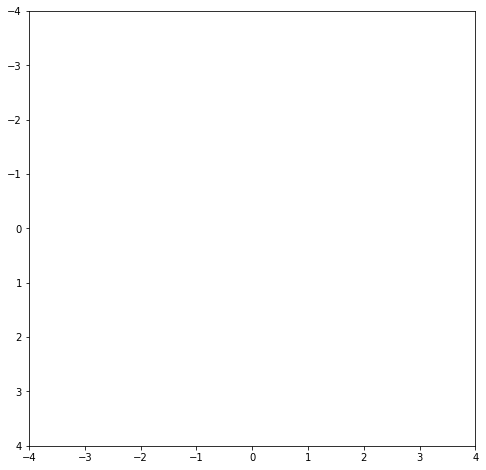

In [31]:
plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().invert_yaxis()
end_state_idxs = np.arange(99, replay_pool.size, 100)
end_states = replay_pool.data[('observations', 'state_observation')][non_zero_rows][end_state_idxs]

success = np.where(np.linalg.norm(end_states - np.array([3, 3]), axis=-1) < 1)[0]
include_idxs = end_state_idxs[success]
include_idxs.shape

all_idxs_to_include = np.concatenate([
    np.arange(include_idx - 99, include_idx + 1)
    for include_idx in include_idxs
])

success_data = replay_pool.data[('observations', 'state_observation')][non_zero_rows][all_idxs_to_include]

# plt.scatter(end_states[:, 0], end_states[:, 1], alpha=0.05)
plt.scatter(end_states[success][:, 0], end_states[success][:, 1], alpha=0.05)

In [32]:
success_data.shape

NameError: name 'success_data' is not defined

In [33]:
replay_pool.data[('observations', 'state_observation')][non_zero_rows][0]

array([-3., -3.], dtype=float32)

In [34]:
np.arange(99, replay_pool.size, 100)

array([    99,    199,    299, ..., 999799, 999899, 999999])

# Use a Distance Function Instead

In [35]:
from softlearning.models.utils import get_distance_estimator_from_variant

variant['distance_fn_params'] = {
    'type': 'feedforward_distance_fn',
    'kwargs': {
        'hidden_layer_sizes': (256, ) * 2,
        'observation_keys': None,
        'observation_keys': ('state_observation', ),
#         'kernel_regularizer': tf.keras.regularizers.l2(5e-4)
    }
}

distance_fn = get_distance_estimator_from_variant(variant, train_env)

In [36]:
ddl_optimizer = tf.compat.v1.train.AdamOptimizer(
    learning_rate=3e-4,
    name='distance_fn_optimizer')

loss_object = tf.keras.losses.MeanSquaredError()
def loss(model, s1, s2, distance):
    return loss_object(y_true=distance, y_pred=model([s1, s2]))

def grad(model, s1, s2, distance):
    with tf.GradientTape() as tape:
        loss_value = loss(model, s1, s2, distance)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [37]:
# Keep results for plotting
train_loss_results = []

num_epochs = 501
batch_size = 64

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for i in range(10):
        s1, s2, distance = get_data(replay_pool,
                                    max_path_length,
                                    batch_size=batch_size)

        loss_value, grads = grad(distance_fn, s1, s2, distance)
        optimizer.apply_gradients(zip(grads, distance_fn.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())

    if epoch % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
    if epoch % 50 == 0:
        clear_output()
        plot_embedding()

InvalidArgumentError: cannot compute ConcatV2 as input #1(zero-based) was expected to be a float tensor but is a uint64 tensor [Op:ConcatV2] name: concat

In [104]:
def plot_embedding():
    target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

    n_samples = 50
    obs_space = train_env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)

    xys = np.meshgrid(xs, ys)

    grid_vals = np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2))
    goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
    dists = distance_fn.predict([grid_vals, goal_vals])

    plt.figure(figsize=(8, 8))

    plt.imshow(train_env.render('rgb_array', width=256, height=256),
               extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

    plt.gca().invert_yaxis()
    plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=30, zorder=1)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

    plt.title(f'd(s, g) for {domain + task} Task'
              + f'Target Pos: {target_pos}')
    plt.show()